# PROJECT PHASE

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Load datasets from GitHub 
perf = pd.read_csv("https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/trainperf.csv")
demo = pd.read_csv("https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/traindemographics.csv")
prev = pd.read_csv("https://raw.githubusercontent.com/Oyeniran20/axia_cohort_8/refs/heads/main/trainprevloans.csv")

# Check dataset sizes
print("Performance:", perf.shape)
print("Demographics:", demo.shape)
print("Previous Loans:", prev.shape)

# Show first 5 rows of each
print("\n=== PERFORMANCE DATA ===")
print(perf.head())

print("\n=== DEMOGRAPHICS DATA ===")
print(demo.head())

print("\n=== PREVIOUS LOANS DATA ===")
print(prev.head())

Performance: (4368, 10)
Demographics: (4346, 9)
Previous Loans: (18183, 12)

=== PERFORMANCE DATA ===
                         customerid  systemloanid  loannumber  \
0  8a2a81a74ce8c05d014cfb32a0da1049     301994762          12   
1  8a85886e54beabf90154c0a29ae757c0     301965204           2   
2  8a8588f35438fe12015444567666018e     301966580           7   
3  8a85890754145ace015429211b513e16     301999343           3   
4  8a858970548359cc0154883481981866     301962360           9   

                 approveddate                creationdate  loanamount  \
0  2017-07-25 08:22:56.000000  2017-07-25 07:22:47.000000     30000.0   
1  2017-07-05 17:04:41.000000  2017-07-05 16:04:18.000000     15000.0   
2  2017-07-06 14:52:57.000000  2017-07-06 13:52:51.000000     20000.0   
3  2017-07-27 19:00:41.000000  2017-07-27 18:00:35.000000     10000.0   
4  2017-07-03 23:42:45.000000  2017-07-03 22:42:39.000000     40000.0   

   totaldue  termdays referredby good_bad_flag  
0   34500.0        

#### STEP 2: CLEAN EACH DATASET

In [4]:
# Step 2A: Clean Performance Data
print("=== Cleaning Performance Data ===")

# Create binary target
perf['loan_default'] = perf['good_bad_flag'].map({'Good': 0, 'Bad': 1})

# Select relevant columns
perf_clean = perf[[
    'customerid',
    'loanamount',
    'totaldue',
    'termdays',
    'loan_default'
]].copy()

# Rename for clarity
perf_clean.rename(columns={
    'loanamount': 'loan_amount',
    'totaldue': 'total_due',
    'termdays': 'term_days'
}, inplace=True)

# Feature engineering: interest/fee ratio
perf_clean['interest_ratio'] = (perf_clean['total_due'] - perf_clean['loan_amount']) / perf_clean['loan_amount']

print("perf_clean shape:", perf_clean.shape)
print("\nFirst 5 rows:")
print(perf_clean.head())

=== Cleaning Performance Data ===
perf_clean shape: (4368, 6)

First 5 rows:
                         customerid  loan_amount  total_due  term_days  \
0  8a2a81a74ce8c05d014cfb32a0da1049      30000.0    34500.0         30   
1  8a85886e54beabf90154c0a29ae757c0      15000.0    17250.0         30   
2  8a8588f35438fe12015444567666018e      20000.0    22250.0         15   
3  8a85890754145ace015429211b513e16      10000.0    11500.0         15   
4  8a858970548359cc0154883481981866      40000.0    44000.0         30   

   loan_default  interest_ratio  
0             0          0.1500  
1             0          0.1500  
2             0          0.1125  
3             0          0.1500  
4             0          0.1000  


#### Step 2B: Clean traindemographics.csv

In [5]:
import pandas as pd
from datetime import datetime

# Make sure 'demo' is already loaded
print("=== Cleaning Demographics Data ===")

# Create a clean copy
demo_clean = demo.copy()

# Convert 'birthdate' to datetime
demo_clean['birthdate'] = pd.to_datetime(demo_clean['birthdate'])

# Calculate age
current_year = datetime.now().year
demo_clean['age'] = current_year - demo_clean['birthdate'].dt.year

# Fill missing categorical values with 'Unknown'
cat_cols = ['bank_branch_clients', 'employment_status_clients', 'level_of_education_clients']
for col in cat_cols:
    demo_clean[col] = demo_clean[col].fillna('Unknown')

# Map employment status to a risk score
employment_map = {
    'Permanent': 0,        # Low risk
    'Self-Employed': 1,    # Medium
    'Contract': 1,
    'Unemployed': 2,       # High risk
    'Unknown': 1
}
demo_clean['emp_risk_score'] = demo_clean['employment_status_clients'].map(employment_map)

# Map education level to a score
education_map = {
    'Primary': 1,
    'Secondary': 2,
    'Tertiary': 3,
    'Unknown': 1
}
demo_clean['edu_level_score'] = demo_clean['level_of_education_clients'].map(education_map)

# Keep only useful columns
demo_clean = demo_clean[[
    'customerid',
    'age',
    'emp_risk_score',
    'edu_level_score'
]].copy()

# Show result
print("demo_clean shape:", demo_clean.shape)
print("\nFirst 5 rows of cleaned demographics:")
print(demo_clean.head())

=== Cleaning Demographics Data ===
demo_clean shape: (4346, 4)

First 5 rows of cleaned demographics:
                         customerid  age  emp_risk_score  edu_level_score
0  8a858e135cb22031015cbafc76964ebd   52             1.0              1.0
1  8a858e275c7ea5ec015c82482d7c3996   39             0.0              1.0
2  8a858e5b5bd99460015bdc95cd485634   38             1.0              1.0
3  8a858efd5ca70688015cabd1f1e94b55   34             0.0              1.0
4  8a858e785acd3412015acd48f4920d04   43             0.0              1.0


#### Step 2C: Clean trainprevloans.csv


In [8]:

print("=== Cleaning Previous Loans Data ===")

# Make a copy
prev_clean = prev.copy()

# Convert date columns to datetime
date_cols = ['approveddate', 'creationdate', 'closeddate', 'firstduedate', 'firstrepaiddate']
for col in date_cols:
    prev_clean[col] = pd.to_datetime(prev_clean[col])

# Calculate days late: firstrepaiddate - firstduedate
prev_clean['days_late'] = (prev_clean['firstrepaiddate'] - prev_clean['firstduedate']).dt.days

# Only keep positive values (if repaid early, count as 0 days late)
prev_clean['days_late'] = prev_clean['days_late'].apply(lambda x: max(0, x) if pd.notnull(x) else x)

# Create a flag for late repayment
prev_clean['was_late'] = (prev_clean['days_late'] > 0).astype(int)

# Group by customerid to create summary features
loans_summary = prev_clean.groupby('customerid').agg(
    prev_loan_count=('systemloanid', 'count'),              # total number of past loans
    avg_days_late=('days_late', 'mean'),                    # average days late
    max_days_late=('days_late', 'max'),                     # worst single delay
    late_repayment_rate=('was_late', 'mean'),               # % of loans paid late
    total_past_loan_amount=('loanamount', 'sum')            # total borrowed before
).reset_index()

# Handle missing values (e.g., customers with no late data)
loans_summary['avg_days_late'] = loans_summary['avg_days_late'].fillna(0)
loans_summary['max_days_late'] = loans_summary['max_days_late'].fillna(0)
loans_summary['late_repayment_rate'] = loans_summary['late_repayment_rate'].fillna(0)

# Round decimals
loans_summary = loans_summary.round(2)

# Show result
print("loans_summary shape:", loans_summary.shape)
print("\nFirst 5 rows:")
print(loans_summary.head())


=== Cleaning Previous Loans Data ===
loans_summary shape: (4359, 6)

First 5 rows:
                         customerid  prev_loan_count  avg_days_late  \
0  8a1088a0484472eb01484669e3ce4e0b                1           6.00   
1  8a1a1e7e4f707f8b014f797718316cad                4           0.25   
2  8a1a32fc49b632520149c3b8fdf85139                7           0.14   
3  8a1eb5ba49a682300149c3c068b806c7                8           1.00   
4  8a1edbf14734127f0147356fdb1b1eb2                2           0.00   

   max_days_late  late_repayment_rate  total_past_loan_amount  
0              6                 1.00                 10000.0  
1              1                 0.25                 70000.0  
2              1                 0.14                 90000.0  
3              8                 0.12                130000.0  
4              0                 0.00                 20000.0  


### #Step 3: Merge All Datasets


In [9]:
# Step 3: Merge All Datasets
print("=== Merging All Datasets ===")

# Start with performance (target variable)
final_df = perf_clean.copy()

# Merge with demographics (left join on customerid)
final_df = final_df.merge(demo_clean, on='customerid', how='left')
print(f"After merging demographics: {final_df.shape}")

# Merge with previous loans summary
final_df = final_df.merge(loans_summary, on='customerid', how='left')
print(f"After merging loans: {final_df.shape}")

# Handle any remaining missing values
final_df.fillna({
    'emp_risk_score': 1,           # 'Unknown'
    'edu_level_score': 1,          # 'Unknown'
    'prev_loan_count': 0,
    'avg_days_late': 0,
    'max_days_late': 0,
    'late_repayment_rate': 0,
    'total_past_loan_amount': 0
}, inplace=True)

# Confirm no missing values
print("\nMissing values after merge and fill:")
print(final_df.isnull().sum().sum(), "total missing values")

# Final check
print("\nFinal dataset shape:", final_df.shape)
print("\nFirst 5 rows of final merged dataset:")
print(final_df.head())

=== Merging All Datasets ===
After merging demographics: (4376, 9)
After merging loans: (4376, 14)

Missing values after merge and fill:
1099 total missing values

Final dataset shape: (4376, 14)

First 5 rows of final merged dataset:
                         customerid  loan_amount  total_due  term_days  \
0  8a2a81a74ce8c05d014cfb32a0da1049      30000.0    34500.0         30   
1  8a85886e54beabf90154c0a29ae757c0      15000.0    17250.0         30   
2  8a8588f35438fe12015444567666018e      20000.0    22250.0         15   
3  8a85890754145ace015429211b513e16      10000.0    11500.0         15   
4  8a858970548359cc0154883481981866      40000.0    44000.0         30   

   loan_default  interest_ratio   age  emp_risk_score  edu_level_score  \
0             0          0.1500  53.0             0.0              1.0   
1             0          0.1500  40.0             0.0              1.0   
2             0          0.1125  41.0             0.0              1.0   
3             0         

### Step 4: Exploratory Data Analysis (EDA) 

#### We’ll answer key questions like:
(1)How many good vs bad loans are there?
(2)Do older customers default less?
(3)Are customers who were late before more likely to default now?
(4)Does loan amount or interest rate affect default?


In [ ]:
First import all the necces


In [15]:

import matplotlib.pyplot as plt
import seaborn as sns

# Make all charts look clean and professional
sns.set(style="whitegrid")

# Set default chart size (bigger = easier to read)
plt.rcParams['figure.figsize'] = (10, 6)

In [14]:
print("=== Loan Default Distribution ===")
print(final_df['loan_default'].value_counts())

# As percentages
print("\n=== Default Rate ===")
print(final_df['loan_default'].value_counts(normalize=True) * 100)

=== Loan Default Distribution ===
loan_default
0    3423
1     953
Name: count, dtype: int64

=== Default Rate ===
loan_default
0    78.222121
1    21.777879
Name: proportion, dtype: float64


In [ ]:
the above is aimed to check target variables


###### Plot the Target (Bar Chart)


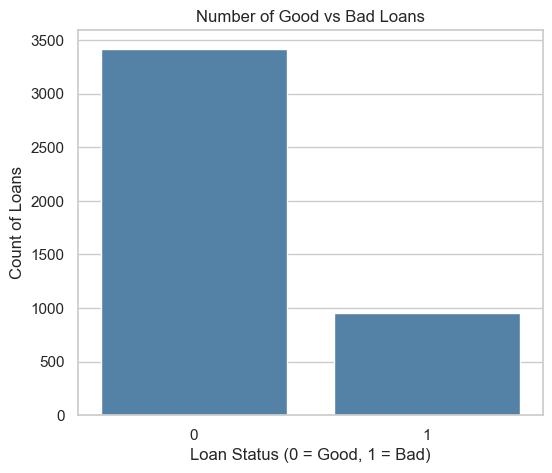

In [17]:
plt.figure(figsize=(6, 5))
sns.countplot(x='loan_default', data=final_df, color='steelblue')
plt.title('Number of Good vs Bad Loans')
plt.xlabel('Loan Status (0 = Good, 1 = Bad)')
plt.ylabel('Count of Loans')
plt.show()

#### Next Step:  — Explore How Age Affects Loan Default
We want to answer:

❓ Are younger customers more likely to default than older ones? 

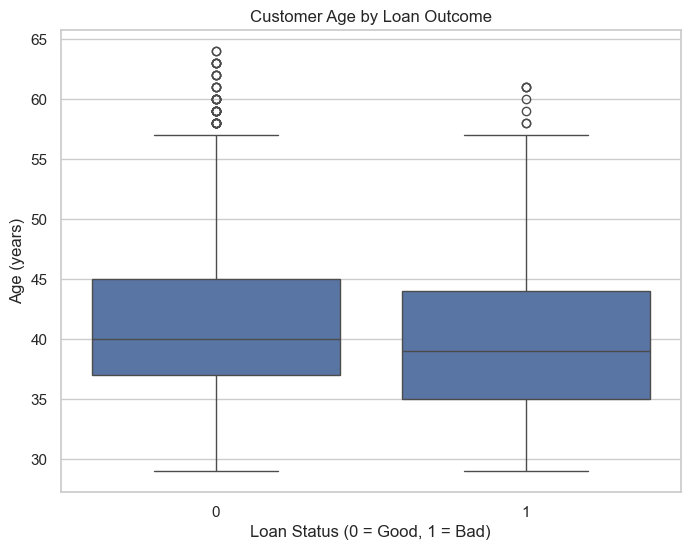

In [18]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='loan_default', y='age', data=final_df)
plt.title('Customer Age by Loan Outcome')
plt.xlabel('Loan Status (0 = Good, 1 = Bad)')
plt.ylabel('Age (years)')
plt.show()

#### 📊 What to Look For
Key points to note

Is the median age (middle line in the box) higher for 0 (Good) or 1 (Bad)?
If the median is lower in the 1 group → younger people are defaulting more.
Is there a big difference in the boxes?
Overlapping boxes = small difference
Separate boxes = strong pattern
Any outliers?
Dots outside the whiskers = very old or very young customers

### Step 4.5: Employment Risk Score vs Default
Employment Risk Score vs Default

We created emp_risk_score earlier:

0 = Permanent (low risk)
1 = Self-Employed, Contract, Unknown
2 = Unemployed (high risk)
Let’s see if higher risk = more defaults.

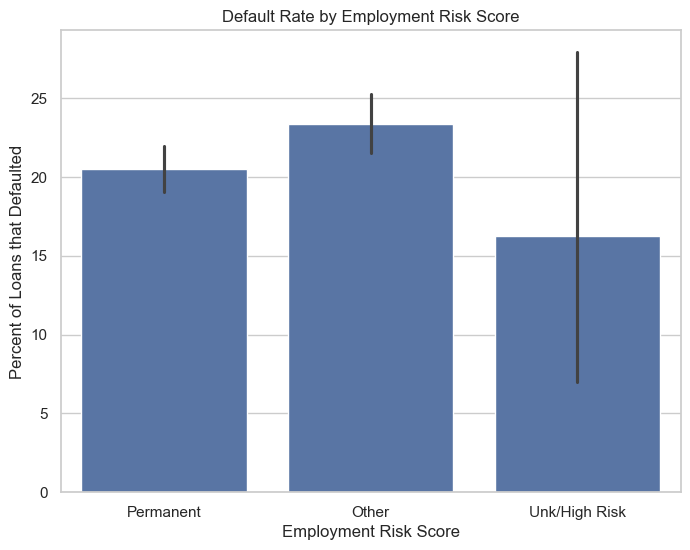

In [19]:
plt.figure(figsize=(8, 6))
sns.barplot(
    x='emp_risk_score',
    y='loan_default',
    data=final_df,
    estimator=lambda x: sum(x) / len(x) * 100  # % of loans that defaulted
)
plt.title('Default Rate by Employment Risk Score')
plt.ylabel('Percent of Loans that Defaulted')
plt.xlabel('Employment Risk Score')
plt.xticks([0, 1, 2], ['Permanent', 'Other', 'Unk/High Risk'])
plt.show()

### Past Late Payments vs Default

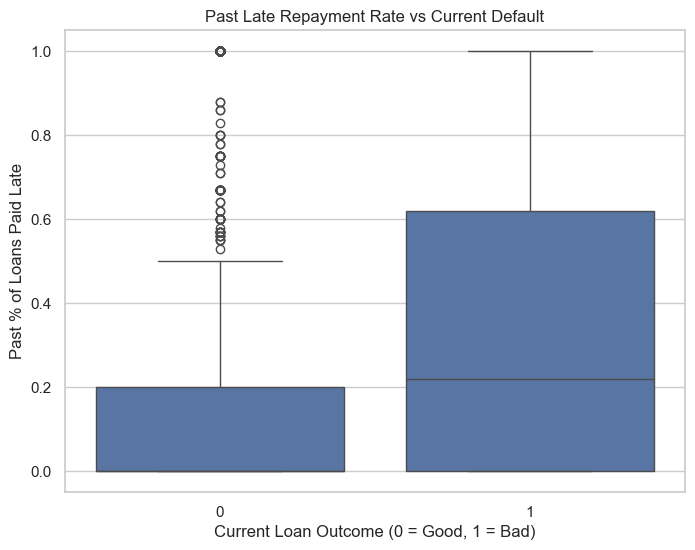

In [20]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='loan_default', y='late_repayment_rate', data=final_df)
plt.title('Past Late Repayment Rate vs Current Default')
plt.xlabel('Current Loan Outcome (0 = Good, 1 = Bad)')
plt.ylabel('Past % of Loans Paid Late')
plt.show()

##### How to Interpret the Chart
The median (middle line in the box) for 1 is higher than for 0
The whole box (middle 50% of values) is shifted up
Some dots (outliers) may show people who were always late


#### Loan Amount vs Default

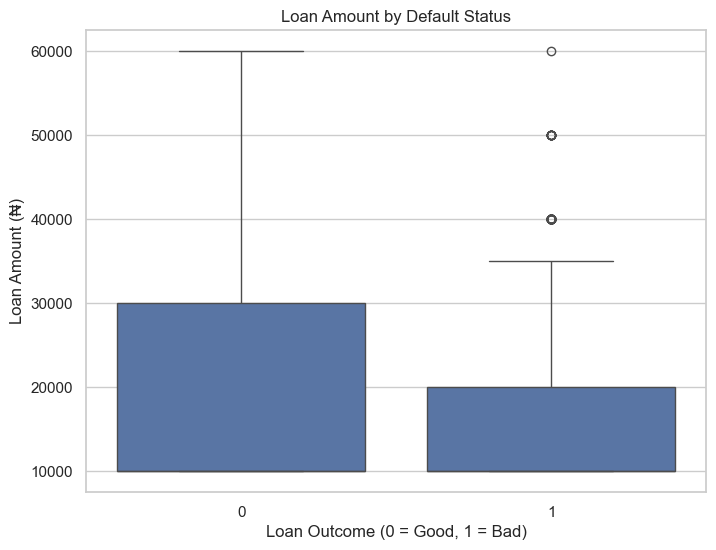

In [23]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='loan_default', y='loan_amount', data=final_df)
plt.title('Loan Amount by Default Status')
plt.xlabel('Loan Outcome (0 = Good, 1 = Bad)')
plt.ylabel('Loan Amount (₦)')
plt.show()

#### Interest Ratio vs Default
We want to know:
 Do more expensive loans (high interest) lead to more defaults? 
 If a customer has to pay back a lot more than they borrowed, they might struggle → higher chance of default.
 interest_ratio = (total_due - loan_amount) / loan_amount

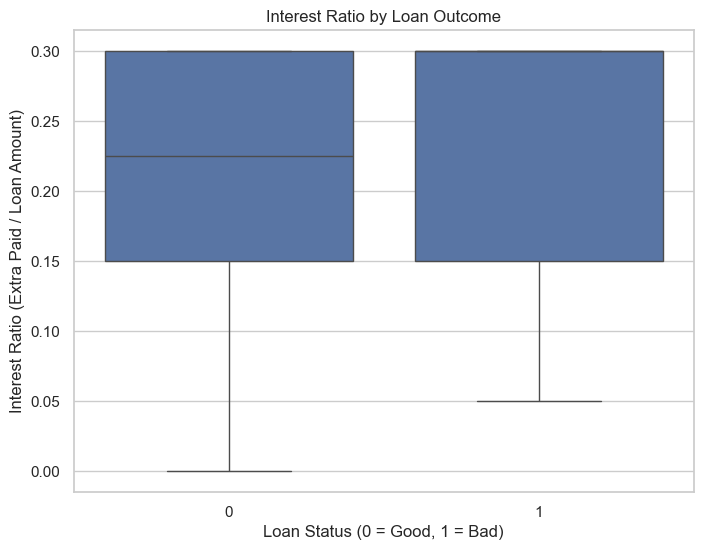

In [24]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='loan_default', y='interest_ratio', data=final_df)
plt.title('Interest Ratio by Loan Outcome')
plt.xlabel('Loan Status (0 = Good, 1 = Bad)')
plt.ylabel('Interest Ratio (Extra Paid / Loan Amount)')
plt.show()

In [ ]:
The interest ratio (cost of borrowing) is lower for customers who defaulted (Bad)
Or said another way: Good loans have higher interest ratios on average

What This Means
 "Why would good loans have higher interest ratios?" 

Possible explanations:

Risk-based pricing: The lender charges higher rates to riskier customers — but still, most of them repay anyway → so high-interest loans are often "Good"
Short-term loans: High interest ratio might come from very short terms (e.g., 7–15 days), not long-term debt
Small loan bias: Smaller loans often have higher fees/interest, but are still repaid
👉 So: High cost ≠ more defaults
In fact, customers who pay back on time are often the ones who took short, expensive loans

This is common in micro-lending or payday loan systems.



#### Step 5: Define Features (X) and Target (y)
We need to separate:

Features → input variables (X)
Target → what we’re predicting: loan_default (y)

In [25]:
feature_columns = [
    'loan_amount',
    'term_days',
    'interest_ratio',
    'age',
    'emp_risk_score',
    'edu_level_score',
    'prev_loan_count',
    'avg_days_late',
    'max_days_late',
    'late_repayment_rate',
    'total_past_loan_amount'
]

# Create X (features) and y (target)
X = final_df[feature_columns]
y = final_df['loan_default']

# Confirm shapes
print("Number of features:", X.shape[1])
print("Total samples:", X.shape[0])
print("Target distribution:\n", y.value_counts())

Number of features: 11
Total samples: 4376
Target distribution:
 loan_default
0    3423
1     953
Name: count, dtype: int64


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 3500
Test set size: 876


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Define features and target
feature_columns = [
    'loan_amount',
    'term_days',
    'interest_ratio',
    'age',
    'emp_risk_score',
    'edu_level_score',
    'prev_loan_count',
    'avg_days_late',
    'max_days_late',
    'late_repayment_rate',
    'total_past_loan_amount'
]

X = final_df[feature_columns]
y = final_df['loan_default']

# Split the data first
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Create an imputer that fills missing values with the MEDIAN
imputer = SimpleImputer(strategy='median')

# Fit the imputer on training data, then transform both train and test
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Now train the model on the imputed data
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_imputed, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test_imputed)
y_pred_proba_lr = lr_model.predict_proba(X_test_imputed)[:, 1]

# Evaluate
print("=== Logistic Regression Results ===")
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_lr))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

=== Logistic Regression Results ===
ROC-AUC Score: 0.7093552948370085

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.88       685
           1       0.69      0.15      0.25       191

    accuracy                           0.80       876
   macro avg       0.75      0.57      0.57       876
weighted avg       0.78      0.80      0.75       876



C:\Users\moray\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Train Random Forest Classifier
Random Forest is great because:

It handles non-linear patterns
It works well with mixed feature type
We can use class_weight='balanced' to focus on rare defaults

In [33]:
from sklearn.ensemble import RandomForestClassifier

# Improved Random Forest with better parameters
rf_model_v2 = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Train on imputed data
rf_model_v2.fit(X_train_imputed, y_train)

# Predict
y_pred_rf_v2 = rf_model_v2.predict(X_test_imputed)
y_pred_proba_rf_v2 = rf_model_v2.predict_proba(X_test_imputed)[:, 1]

# Evaluate
print("=== Improved Random Forest Results ===")
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_rf_v2))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_v2))

=== Improved Random Forest Results ===
ROC-AUC Score: 0.6941758703710781

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       685
           1       0.44      0.42      0.43       191

    accuracy                           0.76       876
   macro avg       0.64      0.63      0.64       876
weighted avg       0.75      0.76      0.75       876



# MODELLING

#### THE Random Forest underperformed likely due to:

Poor hyperparameter settings,
Lack of proper scaling or feature engineering,
Class imbalance not fully addressed.

Hence there is need to improve model performance.
TO DO SO:
 Step 1: Use a Better Model That Handles NaN Values Natively
From the scikit-learn documentation , some models can handle missing values directly:

✅ HistGradientBoostingClassifier is designed to handle NaN values natively 

So we don’t need imputation — and it often outperforms Random Forest!

In [34]:
from sklearn.ensemble import HistGradientBoostingClassifier

# Train HistGradientBoosting (handles NaN automatically)
hgb_model = HistGradientBoostingClassifier(
    random_state=42,
    class_weight='balanced'  # Focus on catching defaults
)

# Fit directly on X_train (no imputation needed!)
hgb_model.fit(X_train, y_train)

# Predict
y_pred_hgb = hgb_model.predict(X_test)
y_pred_proba_hgb = hgb_model.predict_proba(X_test)[:, 1]

# Evaluate
print("=== Histogram-Based Gradient Boosting Results ===")
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba_hgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_hgb))

C:\Users\moray\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\moray\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\moray\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\moray\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\moray\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

=== Histogram-Based Gradient Boosting Results ===
ROC-AUC Score: 0.6589138991859977

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       685
           1       0.37      0.43      0.40       191

    accuracy                           0.71       876
   macro avg       0.60      0.61      0.60       876
weighted avg       0.73      0.71      0.72       876



#### 📊 Step 2: Compare All Models Side-by-Side
Once WE  have results from:

Logistic Regression
Random Forest
HistGradientBoosting
Create a comparison table:

In [35]:
# Model Comparison
print("🎯 FINAL MODEL COMPARISON")
print(f"Logistic Regression AUC: {roc_auc_score(y_test, y_pred_proba_lr):.3f}")
print(f"Random Forest AUC:       {roc_auc_score(y_test, y_pred_proba_rf):.3f}")
print(f"HistGradientBoosting AUC: {roc_auc_score(y_test, y_pred_proba_hgb):.3f}")

🎯 FINAL MODEL COMPARISON
Logistic Regression AUC: 0.709
Random Forest AUC:       0.645
HistGradientBoosting AUC: 0.659


##### 🔍 Step 3: Feature Importance (Explain Your Best Model)
Show which features matter most:

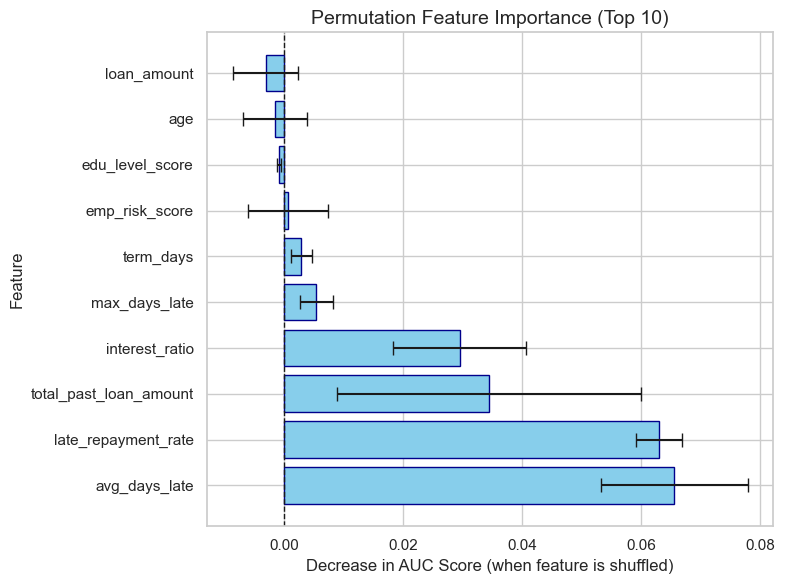

In [41]:
import matplotlib.pyplot as plt

# Use top 10 features
top10 = importance_df.head(10)

# Create horizontal bar chart with error bars
plt.figure(figsize=(8, 6))
plt.barh(
    top10['feature'],
    top10['importance_mean'],
    xerr=top10['importance_std'],
    color='skyblue',
    edgecolor='darkblue',
    capsize=5
)

# Add vertical line at x=0
plt.axvline(x=0, color='k', linestyle='--', linewidth=1)

# Labels and title
plt.title('Permutation Feature Importance (Top 10)', fontsize=14)
plt.xlabel('Decrease in AUC Score (when feature is shuffled)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
